<a href="https://colab.research.google.com/github/kbarakat/TEST_ME_KB/blob/main/Copy_of_hERG_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install dependencies and mount Drive**

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
%%capture
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
#@title **Mount Drive**
#@markdown Mount GoogleDrive to access data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**
# Check available resources
import os
if_GPU = bool(os.environ["COLAB_GPU"])
if if_GPU:
  print("a GPU is connected.")
else:
  print("No accelerator is connected. Only CPU.")
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')

a GPU is connected.


In [ ]:
#@title **Please, provide the name of the main directory:**
import os

# change current working directory
os.chdir('/content/drive/My Drive/')

# function to create directories
def create_directory(directory_path):
    """
    Create <directory_path> if it does not exist.
    Args:
    - directory_path (Path)
    """
    if not os.path.exists(directory_path):
        os.mkdir(directory_path)
        print(f"'{directory_path}' has been created!")
    else:
        print(f"'{directory_path}' already exists!")

# create main directory
parentDir = '/content/drive/My Drive/'
directory = 'rank3' #@param {type:"string"}

mainDir = os.path.join(parentDir, directory)
create_directory(mainDir)
#@markdown ---

'/content/drive/My Drive/rank3' already exists!


## **Setting the environment for MD simulations**

Firstly, we need to install all necessary libraries and packages for our simulations. The main tools we will be installing are:

1. Anaconda
2. AmberTools
3. NAMD v2.14
4. VMD (text interface)

In [ ]:
#@title **Download NAMD and VMD**
%%capture
mdDirectory = os.path.join(parentDir, 'md')
create_directory(mdDirectory)
os.chdir('/content/drive/My Drive/md')

# NAMD
# Check available resources
if if_GPU:
    namdVersion = "NAMD_2.14_Linux-x86_64-multicore-CUDA.tar.gz"
else:
    namdVersion = "NAMD_2.14_Linux-x86_64-multicore.tar.gz"
# Download
if not os.path.exists(f'./{namdVersion[:-7]}/namd2'):
    mdLink = f"https://www.ks.uiuc.edu/Research/namd/2.14/download/946183/{namdVersion}"
    !wget $mdLink
    # Uncomprise
    !tar -zxf $namdVersion

# Download VMD (used to generate pdb and psf file for the experiment, for run tcl scripts and for result analysis)
if not os.path.exists(f'./md/vmd-1.9.3'):
    !wget https://www.ks.uiuc.edu/Research/vmd/vmd-1.9.3/files/final/vmd-1.9.3.bin.LINUXAMD64.text.tar.gz
    !tar -zxf vmd-1.9.3.bin.LINUXAMD64.text.tar.gz

In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes.

%%capture
# # AmberTools
# !rm -rf /usr/local/conda-meta/pinned
# !mamba install -c conda-forge ambertools -y

# NAMD
mdDirectory = os.path.join(parentDir, 'md')
create_directory(mdDirectory)
os.chdir(mdDirectory)
# Check available resources
if if_GPU:
    namdVersion = "NAMD_2.14_Linux-x86_64-multicore-CUDA.tar.gz"
else:
    namdVersion = "NAMD_2.14_Linux-x86_64-multicore.tar.gz"
# Change accessibility of the google drive folder
!chmod 755 -R /content/drive/MyDrive/md
namd2 = f'/content/drive/MyDrive/md/{namdVersion[:-7]}/namd2'

# VMD
os.chdir('/content/drive/My Drive/md/vmd-1.9.3')
!./configure
os.chdir('/content/drive/My Drive/md/vmd-1.9.3/src')
!sudo make install

# python modules
import subprocess
import re
import os
import tarfile
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# **Directory structure**


In [ ]:
#@title **Create directories**
#@markdown common, mineq01, mineq02, eq03, smd, abf and merge directories will be created

import os

commonDir = os.path.join(mainDir, 'common')
create_directory(commonDir)

mineq01Dir = os.path.join(mainDir, 'mineq01')
create_directory(mineq01Dir)

mineq02Dir = os.path.join(mainDir, 'mineq02')
create_directory(mineq02Dir)

eq03Dir = os.path.join(mainDir, 'eq03')
create_directory(eq03Dir)

smdDir = os.path.join(mainDir, 'smd')
create_directory(smdDir)

abfDir = os.path.join(mainDir, 'abf')
create_directory(abfDir)

pmfDir = os.path.join(mainDir, 'merge')
create_directory(pmfDir)

'/content/drive/My Drive/rank3/common' already exists!
'/content/drive/My Drive/rank3/mineq01' already exists!
'/content/drive/My Drive/rank3/mineq02' already exists!
'/content/drive/My Drive/rank3/eq03' already exists!
'/content/drive/My Drive/rank3/smd' already exists!
'/content/drive/My Drive/rank3/abf' already exists!
'/content/drive/My Drive/rank3/merge' already exists!


# **Get CHARMM parameters**
The system is parameterized using the CHARMM36 force field. The structural parameters for all the drugs is obtained from the Swissparam server.

4. Generate the Charmm parameters for the ligand by using swissparam.ch server

In [ ]:
#@title **Required files**
#@markdown Check if the required files are in the common directory

# check if required files are present
mol2File = 'hit.mol2' #@param {type:"string"}

for f in [mol2File]:
    pathFile = os.path.join(commonDir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

yes	 /content/drive/My Drive/rank3/common/hit.mol2


In [ ]:
#@title **Launch parametrization**
os.chdir(commonDir)
# Connect to server
!curl -s swissparam.ch:5678/
# Launch parametrization
inputFile = f'./{mol2File}'
#@markdown Choose parameters approach: match (CHARMM), mmff-based or both
approach = "mmff-based" #@param {type:"string"}
swissPath = f"swissparam.ch:5678/startparam?approach={approach}"
mol2Path = f"myMol2=@{inputFile}"
# Define the command
command = f"curl -s -F '{mol2Path}' '{swissPath}'"
# Execute the command and capture the output
output = subprocess.check_output(command, shell=True).decode('utf-8')

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
Hello World!


In [ ]:
#@title **Extract the session number**
session_number_match = re.search(r'Session number: (\d+)', output)
if session_number_match:
    session_number = int(session_number_match.group(1))
    print("Session number:", session_number)
else:
    print("Session number not found in the output.")

Session number: 28407110


In [ ]:
#@title **Get parameters**
origin = f"swissparam.ch:5678/retrievesession?sessionNumber={session_number}"
destination = f"./results.tar.gz"
!curl "$origin" -o $destination

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20292    0 20292    0     0  64480      0 --:--:-- --:--:-- --:--:-- 64419


In [ ]:
#@title **Extract parameters from results.tar.gz**
try:
    with tarfile.open(f"./results.tar.gz", "r:gz") as tar:
        tar.extractall(path=commonDir)
    print(f"Successfully extracted results.tar.gz to {commonDir}.")
except tarfile.TarError as e:
    print(f"Error occurred while extracting results.tar.gz: {e}")
!rm ./results.tar.gz

Successfully extracted results.tar.gz to /content/drive/My Drive/rank3/common.


# **Equilibration of the drug-channel complex**

5. Embed the complex to membrane

6. Run Simulations - mineq01, mineq02, eq03 and eq03cont

## **System preparation**

The complex of drug bound hERG channel is embedded into a 120 X 120 Å POPC lipid bilayer using the Membrane plugin of the VMD sofware. The solvate plugin of VMD package was used to solvate the membrane-embedded complex of the
drug-hERG channel with TIP3P water. Te autoionize plugin was used to electro-neutralize the system and increase its ionic concentration to 150 mM of KCl. The complex system include more than 140,000 atoms.

In [ ]:
#@title **Required files**
#@markdown Check if the required files are in the common directory
os.chdir(commonDir)

pdbFile = 'complex_3_Vandetanib.pdb' #@param {type:"string"}
parsFile = 'unk.rtf' #@param {type:"string"}
protFile = 'top_all36_prot.rtf' #@param {type:"string"}
lipidFile = 'top_all36_lipid.rtf' #@param {type:"string"}

for f in [pdbFile, parsFile, protFile, lipidFile]:
    pathFile = os.path.join(commonDir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

yes	 /content/drive/My Drive/rank3/common/complex_3_Vandetanib.pdb
yes	 /content/drive/My Drive/rank3/common/unk.rtf
yes	 /content/drive/My Drive/rank3/common/top_all36_prot.rtf
yes	 /content/drive/My Drive/rank3/common/top_all36_lipid.rtf


In [ ]:
#@title **Write preparation file**

import os
commonDir = os.path.join(mainDir, 'common')
os.chdir(commonDir)

#@markdown Name of the tcl preparation file that will be used in VMD.
prepFile = 'Systemprep.tcl' #@param {type:"string"}

content = f"mol new {pdbFile}" + \
"""

proc preptetra {sel} {
  set proA [atomselect top "protein and chain A"]
  puts "Writing segA..."
  $proA set segname A
  $proA writepdb segA.pdb
  set proB [atomselect top "protein and chain B"]
  puts "writing segB..."
  $proB set segname B
  $proB writepdb segB.pdb
  set proC [atomselect top "protein and chain C"]
  puts "Writing segC..."
  $proC set segname C
  $proC writepdb segC.pdb
  set proD [atomselect top "protein and chain D"]
  puts "Writing segD..."
  $proD set segname D
  $proD writepdb segD.pdb
  set ligX [atomselect top "resname UNK"]
  puts "Writing ligand..."
  $ligX set segname X
  $ligX writepdb UNK.pdb
  $proA delete
  $proB delete
  $proC delete
  $proD delete
  $ligX delete
}

proc preppsf {} {
  mol delete all
  package require psfgen
  topology  ./top_all36_prot.rtf
  topology  ./top_all36_lipid.rtf
""" +\
f'  topology  ./{parsFile}' +\
"""
  pdbalias residue HIS HSE
  pdbalias atom ILE CD1 CD
  foreach S {A B C D} {
    segment $S {
    pdb seg$S.pdb
    }
  coordpdb seg$S.pdb $S
  }
  segment X {
  pdb UNK.pdb
  }
  coordpdb UNK.pdb X

  guesscoord
  puts "Writing pdb complex..."
  writepdb complex.pdb
  writepsf complex.psf
}

proc prepmem {} {
  mol delete all
  package require membrane
  membrane -l POPC -x 120 -y 120 -o popc
  set popc [atomselect top all]
  set hERGmol [mol load psf complex.psf pdb complex.pdb]
  set hERG [atomselect $hERGmol all]
  $popc moveby [vecinvert [measure center $popc weight mass]]
  $popc writepdb popc_TEMP.pdb
  set vest [atomselect $hERGmol "protein and resid 249 to 257 1062 to 1070 520 to 528 790 to 799"]
  $hERG moveby [vecinvert [measure center $vest weight mass]]
  display resetview
  $hERG move [transaxis z -15]
  $hERG writepdb hERG_TEMP.pdb
  mol delete all
  package require psfgen
  resetpsf
  readpsf popc.psf
  coordpdb popc_TEMP.pdb
  readpsf complex.psf
  coordpdb hERG_TEMP.pdb
  puts "Building raw membrane..."
  writepsf hERG_popc_raw.psf
  writepdb hERG_popc_raw.pdb
  file delete hERG_TEMP.pdb
  file delete popc_TEMP.pdb
}

proc removelipwat {} {
  mol delete all
  mol load psf hERG_popc_raw.psf pdb hERG_popc_raw.pdb
  set POPC "resname POPC"
  set all [atomselect top all]
  $all set beta 0
  set seltext1 "$POPC and same residue as (name P1 and z>0 and abs(x)<15 and abs(y)<15)"
  set seltext2 "$POPC and same residue as (name P1 and z<0 and abs(x)<10 and abs(y)<10)"
  set seltext3 "$POPC and same residue as (within 0.6 of protein)"
  set sel1 [atomselect top $seltext1]
  set sel2 [atomselect top $seltext2]
  set sel3 [atomselect top $seltext3]
  $sel1 set beta 1
  $sel2 set beta 1
  $sel3 set beta 1
  set badlipid [atomselect top "name P1 and beta >0"]
  set seglistlipid [$badlipid get segid]
  set reslistlipid [$badlipid get resid]
  set seltext4 "(water and not segname WCA WCB WCC WCD WF SOLV) and same residue as within 3 of ((same residue as (name P1 and beta>0)) or protein)"
  set seltext5 "segname SOLV and same residue as within 3 of lipids"
  set sel4 [atomselect top $seltext4]
  set sel5 [atomselect top $seltext5]
  $sel4 set beta 1
  $sel5 set beta 1
  set badwater [atomselect top "name OH2 and beta >0"]
  set seglistwater [$badwater get segid]
  set reslistwater [$badwater get resid]
  mol delete all
  puts "Cleared overlapping lipids..."
  package require psfgen
  resetpsf
  readpsf hERG_popc_raw.psf
  coordpdb hERG_popc_raw.pdb
  foreach segid $seglistlipid resid $reslistlipid {
    delatom $segid $resid
  }
  foreach segid $seglistwater resid $reslistwater {
    delatom $segid $resid
  }
  puts "Writing membrane embedded system files..."
  writepsf hERG_popc.psf
  writepdb hERG_popc.pdb
}

proc solvrem {} {
  mol delete all
  package require solvate
  solvate hERG_popc.psf hERG_popc.pdb -o hERG_popc_water_TEMP -b 1.5 -minmax {{-58 -59 -58} {58 58 58}}
  set all [atomselect top all]
  $all set beta 0
  set seltext "segid WT1 to WT99 and same residue as abs(z) <25"
  set sel [atomselect top $seltext]
  $sel set beta 1
  set badwater [atomselect top "name OH2 and beta > 0"]
  set seglist [$badwater get segid]
  set reslist [$badwater get resid]
  puts "Clearing unwanted waters..."
  mol delete all
  package require psfgen
  resetpsf
  readpsf hERG_popc_water_TEMP.psf
  coordpdb hERG_popc_water_TEMP.pdb
  foreach segid $seglist resid $reslist {
    delatom $segid $resid
  }
  writepdb hERG_popcw.pdb
  writepsf hERG_popcw.psf
  file delete hERG_popc_water_TEMP.psf
  file delete hERG_popc_water_TEMP.pdb
}

proc ionize {} {
  mol delete all
  package require autoionize
  puts "Ionizing..."
  autoionize -psf hERG_popcw.psf -pdb hERG_popcw.pdb -sc 0.10 -cation POT -seg ION -o hERG_popcwi
}

proc writecons {} {
  mol delete all
  mol new hERG_popcwi.psf
  mol addfile hERG_popcwi.pdb
  set all [atomselect top "all"]
  $all set beta 0
  set prot [atomselect top "backbone"]
  $prot set beta 10
  set lig [atomselect top "resname UNK"]
  $lig set beta 10
  set fixed1 [atomselect top "name CLA POT or  (chain L and name O2 P1 O3 O4 O1 C15 H52 H51 H11 C11 H12   N C14 H42 H43 H41 C12 H22 H23 H21 C13 H33 H31 H32)"]
  $fixed1 set beta 5
  puts "Writing constraint files..."
  $all writepdb hERG_popcwi.cnst
  set all [atomselect top "all"]
  $all set beta 0
  set fixed [atomselect top "name CLA POT or backbone or chain X or  (chain L and name O2 P1 O3 O4 O1 C15 H52 H51 H11 C11 H12   N C14 H42 H43 H41 C12 H22 H23 H21 C13 H33 H31 H32)"]
  $fixed set beta 1
  $all writepdb hERG_popcwi.fix
}

set SOURCE "./"
set fname [glob -dir $SOURCE complex_*.pdb]
puts ${fname}
set sel [mol load pdb ${fname}]
preptetra $sel
puts "Done with preparing the tetra..."

preppsf
prepmem
removelipwat
solvrem
ionize
writecons
exit 0
"""

tclFile = os.path.join(commonDir, prepFile)
with open(tclFile, 'w') as f:
    f.write(content)

print(tclFile, "created successfully!")

/content/drive/My Drive/rank3/common/Systemprep.tcl created successfully!


In [ ]:
#@title **Run VMD for system preparation**
%%capture
# @markdown In the VMD window the commands in `<prepFile>` will be executed

# @markdown In this example `prepFile = Systemprep.tcl`

# run mvd
!vmd -dispdev text -e $prepFile

## **MD Simulation**


### **mineq01**

The protein, ligand and the lipid heads were fixed allowing the other components to relax for 250k steps. This stage was essential to remove any atom overlaps from improper packing of the membrane around the protein.

In [ ]:
#@title **Write conf file**

# create mineq01 directory
mineq01Dir = os.path.join(mainDir, 'mineq01')
os.chdir(mineq01Dir)

# timeStep01 = "0.3" #@param {type:"string"}
# minSteps01 = "20000"  #@param {type:"string"}
# minSteps01 = int(minSteps01)
# equSteps01 = "200000" #@param {type:"string"}
# equSteps01 = int(equSteps01)
minSteps01 = 20000
equSteps01 = 200*100

# write conf file
content = """
#############################################################
## JOB DESCRIPTION                                         ##
#############################################################

# Min. and Eq. of hERG
# embedded in POPC membrane, ions and water.
# Melting lipid tails. PME, Constant Volume.

#############################################################
## ADJUSTABLE PARAMETERS                                   ##
#############################################################

structure           ../common/hERG_popcwi.psf
coordinates         ../common/hERG_popcwi.pdb
outputName          mineq01

set temperature     300
firsttimestep       0

#############################################################
## SIMULATION PARAMETERS                                   ##
#############################################################

# Input
paraTypeCharmm	    on
parameters          ../common/par_all27_prot_lipidNBFIX.prm
parameters	        ../common/par_all36_lipid.prm
parameters	        ../common/par_all36_prot.prm
parameters	        ../common/hit.par

temperature         $temperature

# Periodic Boundary Conditions
cellBasisVector1    123.90  0       0
cellBasisVector2    0       123.25  0
cellBasisVector3    0       0       116.0
cellOrigin          -0.078  -0.14   0.15
wrapWater           on
wrapAll             on

# Force-Field Parameters
exclude             scaled1-4
1-4scaling          1.0
cutoff              12.
switching           on
switchdist          10.
pairlistdist        13.5

# Integrator Parameters

timestep            0.3  ;# fs/step'
rigidBonds          all  ;# needed for 2fs steps
nonbondedFreq       1
fullElectFrequency  2
stepspercycle       20

#PME (for full-system periodic electrostatics)
PME                 yes
PMEGridSizeX        125
PMEGridSizeY        125
PMEGridSizeZ        120

# Constant Temperature Control
langevin            on    ;# do langevin dynamics
langevinDamping     1     ;# damping coefficient (gamma) of 5/ps
langevinTemp        $temperature

restartfreq         1000
dcdfreq             5000
xstFreq             1000
outputEnergies      200
outputPressure      200

# Fixed Atoms Constraint (set PDB beta-column to 1)
fixedAtoms          on
fixedAtomsFile      ../common/hERG_popcwi.fix
fixedAtomsCol       B
fixedAtomsForces    on

#############################################################
## EXECUTION SCRIPT                                        ##
#############################################################

# Minimization
minimize            20000

for { set i 0 } { $i < 100 } { incr i 1 } {
  langevinTemp [expr {(310 - 0)*(double($i)/100) + 0}];
  run 200
}
"""

conf01File = os.path.join(mineq01Dir, 'mineq01.conf')
with open(conf01File, 'w') as f:
    f.write(content)

print(conf01File, "created successfully!")

/content/drive/My Drive/rank3/mineq01/mineq01.conf created successfully!


In [ ]:
#@title **Required files**
#@markdown Check if required files are present

psfFile = 'hERG_popcwi.psf'
pdbFile = 'hERG_popcwi.pdb'
fixFile = 'hERG_popcwi.fix'
parProtLipidFile = 'par_all27_prot_lipidNBFIX.prm'
parLipidFile = 'par_all36_lipid.prm'
parProtFile = 'par_all36_prot.prm'
hitParFile = 'hit.par'

for f in [pdbFile, psfFile, fixFile, parProtLipidFile, parProtFile, parLipidFile, hitParFile]:
    pathFile = os.path.join(commonDir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

yes	 /content/drive/My Drive/rank3/common/hERG_popcwi.pdb
yes	 /content/drive/My Drive/rank3/common/hERG_popcwi.psf
yes	 /content/drive/My Drive/rank3/common/hERG_popcwi.fix
yes	 /content/drive/My Drive/rank3/common/par_all27_prot_lipidNBFIX.prm
yes	 /content/drive/My Drive/rank3/common/par_all36_prot.prm
yes	 /content/drive/My Drive/rank3/common/par_all36_lipid.prm
yes	 /content/drive/My Drive/rank3/common/hit.par


In [ ]:
#@title **Run namd2**
if if_GPU:
  !$namd2 +p2 +devices 0 +idlepoll mineq01.conf > mineq01.log
else:
  !$namd2 mineq01.conf > mineq01.log
!tail -n 20 mineq01.log

GPRESSAVG: 40000 334.888 -260.038 -521.293 467.668 398.349 171.048 53.3082 168.112 117.216
ETITLE:      TS           BOND          ANGLE          DIHED          IMPRP               ELECT            VDW       BOUNDARY           MISC        KINETIC               TOTAL           TEMP      POTENTIAL         TOTAL3        TEMPAVG            PRESSURE      GPRESSURE         VOLUME       PRESSAVG      GPRESSAVG

ENERGY:   40000     70367.0454    113692.8874     38974.1378       892.4971        -422951.7363  70179238.1015         0.0000         0.0000     85891.0180       70066103.9509       256.6692  69980212.9328  70066123.1014       254.8988            616.1780       613.0738   1771398.3000       284.5742       283.4841

WRITING EXTENDED SYSTEM TO RESTART FILE AT STEP 40000
WRITING COORDINATES TO DCD FILE mineq01.dcd AT STEP 40000
WRITING COORDINATES TO RESTART FILE AT STEP 40000
FINISHED WRITING RESTART COORDINATES
WRITING VELOCITIES TO RESTART FILE AT STEP 40000
FINISHED WRITING RESTART VE

In [ ]:
#@title **Extract last equilibration frame**
%%capture

# write in file
content = """mol new ../common/hERG_popcwi.psf
mol addfile mineq01.coor
set sel [atomselect top all]
$sel writepdb end-equ01.pdb
exit 0
"""

inFile = os.path.join(mineq01Dir, 'get_end_equ.tcl')
with open(inFile, 'w') as f:
    f.write(content)

!vmd -dispdev text -e get_end_equ.tcl

### **mineq02**

A 1 kcal/mol.Å harmonic restraint was placed on the protein and ligand atoms, and the system in energy minimized for another 250k steps.

In [ ]:
#@title **Write conf file and tcl file**

# create mineq02 directory
mineq02Dir = os.path.join(mainDir, 'mineq02')
os.chdir(mineq02Dir)

# timeStep02 = "2.0" #@param {type:"string"}
# minSteps02 = "100000" #@param {type:"string"}
# minSteps02 = int(minSteps02)
# equSteps02 = "250000" #@param {type:"string"}
# equSteps02 = int(equSteps02)

minSteps02 = 10000
equSteps02 = 1000*500//2

# write conf file
content = """
#############################################################
## JOB DESCRIPTION                                         ##
#############################################################

# Min. and Eq. of KcsA
# embedded in POPC membrane, ions and water.
# Protein constrained. PME, Constant Pressure.

#############################################################
## ADJUSTABLE PARAMETERS                                   ##
#############################################################

structure          ../common/hERG_popcwi.psf
coordinates        ../common/hERG_popcwi.pdb
outputName         mineq02

set temperature    310

# Continuing a job from the restart files
set inputname      ../mineq01/mineq01
binCoordinates     $inputname.restart.coor
binVelocities      $inputname.restart.vel  ;# remove the "temperature" entry if you use this!
extendedSystem	   $inputname.restart.xsc
""" +\
f'firsttimestep      {minSteps01+equSteps01}\n' +\
"""

#############################################################
## SIMULATION PARAMETERS                                   ##
#############################################################

# Input
paraTypeCharmm	    on
parameters          ../common/par_all27_prot_lipidNBFIX.prm
parameters	        ../common/par_all36_lipid.prm
parameters	        ../common/par_all36_prot.prm
parameters	        ../common/hit.par

# Periodic Boundary Conditions
wrapWater           on
wrapAll             on

# Force-Field Parameters
exclude             scaled1-4
1-4scaling          1.0
cutoff              12.
switching           on
switchdist          10.
pairlistdist        13.5

# Integrator Parameters
timestep            1.0  ;# fs/step
rigidBonds          all  ;# needed for 2fs steps
nonbondedFreq       1
fullElectFrequency  2
stepspercycle       20

#PME (for full-system periodic electrostatics)
PME                 yes
PMEGridSizeX        125
PMEGridSizeY        125
PMEGridSizeZ        120

# Constant Temperature Control
langevin            on    ;# do langevin dynamics
langevinDamping     1     ;# damping coefficient (gamma) of 5/ps
langevinTemp        $temperature

# Constant Pressure Control (variable volume)
useGroupPressure      yes ;# needed for 2fs steps
useFlexibleCell       yes ;# no for water box, yes for membrane
useConstantArea       no  ;# no for water box, yes for membrane

langevinPiston        on
langevinPistonTarget  1.01325 ;#  in bar -> 1 atm
langevinPistonPeriod  200.
langevinPistonDecay   50.
langevinPistonTemp    $temperature

restartfreq         1000     ;# 1000steps = every 2ps
dcdfreq             1000
xstFreq             1000
outputEnergies      50
outputPressure      50

#############################################################
## EXTRA PARAMETERS                                        ##
#############################################################

# Put here any custom parameters that are specific to
# this job (e.g., SMD, TclForces, etc...)

constraints 				on
consexp 						2
consref 						../mineq01/end-equ01.pdb
conskfile 					../common/hERG_popcwi.cnst
conskcol 						B
margin 							3

tclforces 					on
set waterCheckFreq  100
set lipidCheckFreq  100
set allatompdb      ../mineq01/end-equ01.pdb
tclForcesScript     keep_water_out.tcl

#############################################################
## EXECUTION SCRIPT                                        ##
#############################################################

# Minimization
minimize 10000
for { set i 0 } { $i < 500 } { incr i 2 } { ; # incr i 500
run 1000
constraintScaling [expr {(1- (double($i)/500)) }];
}
"""

conf02File = os.path.join(mineq02Dir, 'mineq02.conf')
with open(conf02File, 'w') as f:
    f.write(content)

print(conf02File, "created successfully!")


# write tcl file
content = """
#!/usr/local/bin/namd2
# keep water from entering gaps between protein and lipids
# need membrane be in the XY plane!
# (C) A. Aksimentiev (alek@ks.uiuc.edu)

# This script will prevent water molecules in your namd simulations
# from entering into the hydrophobic part of the membrane. This can be very
# useful for initial equilibration of a protein/lipid/water system.
# It works with recent NAMD binaries (version 2.4 and higher), which
# has clearconfig command.

# Brief description:
# At initialization, the arrays of namd atom indices of all water oxygens
# and of all lipid c21 carbons are created. They will be used later to
# determine which water molecules to push out of the membrane and to compute
# membrane dimensions. At every simulation step the pushing forces are applied
# to a minor number of atoms, which doesn't affect NAMD performance. The
# membrane dimensions are recalculated every N steps (regulated by the global
# parameter $lipidCheckFreq) as well as the indices of the
# water molecules that will be pushed during the next N steps (regulated by
# the global parameter $waterCheckFreq). The membrane should be in XY plane.
# To use this script one has to add the following lines to the namd
# configuration script (without "#" symbol):
#
#
#  set waterCheckFreq              100
#  set lipidCheckFreq              100
#  set allatompdb                  a1b2c5_init.pdb
#  tclForces                       on
#  tclForcesScript                 keep_water_out.tcl
#
# # lipidCheckFreq must be an integer multiple of waterCheckFreq .



###################################################################
# user definitions begin
###################################################################

print "Starting Tcl forces"

# define force constant per group (Kcal/(mol*A))
set fconst 0.1
set pressure 1.0
set fconstUp [expr $fconst*$pressure]
set fconstDown [expr -$fconst*$pressure]

# define water and lipid names
set watResName "TIP3"
set watAtomName "OH2"
set lipResName "POPC"
set lipAtomName "C1 "

# define exceptions

#set watexcept {30621 30624 30627 30630 30633 30642 30648 30654 30669 30678 30687 30690 30711 30717 30720 30744 30747 30756 30759 30762 30768 30801 30807 30816 30828 30843 30846 30852 30864 30888 30906 30927 30933 30936 30957 30960 30972 32546 32549 32552 32555 32558 32567 32579 32594 32603 32612 32615 32636 32642 32645 32669 32672 32681 32684 32687 32693 32726 32732 32741 32753 32768 32771 32777 32789 32813 32831 32852 32858 32861 32882 32885 32897 34471 34474 34477 34480 34483 34492 34498 34504 34519 34528 34537 34540 34561 34567 34570 34594 34597 34606 34609 34612 34618 34651 34657 34666 34678 34684 34693 34696 34702 34714 34738 34756 34777 34783 34786 34798 34807 34810 34822 36396 36399 36402 36405 36408 36417 36429 36444 36453 36462 36465 36486 36492 36495 36519 36522 36531 36534 36537 36543 36576 36582 36591 36603 36618 36621 36627 36639 36663 36681 36702 36708 36711 36732 36735 36747 36754 36757 36760}

###################################################################
# user definitions stop here!
###################################################################



###################################################################
# preprocessing for calcforces
###################################################################

# define all water oxigens and lipid C21 :

set waters_list   {}
set c21plus_list  {}
set c21minus_list {}

set inStream [open $allatompdb r]
foreach line [split [read $inStream] \n] {
    set string1 [string range $line 0 3]
    set string2 [string range $line 6 10]
    set string3 [string range $line 17 20]
    set string4 [string range $line 13 15]
    set string5 [string range $line 46 53]
    set string6 [string range $line 72 75]
    set string7 [string range $line 22 25]

    if { ([string equal $string1 {ATOM}] || \
	      [string equal $string1 {HETA}] ) && \
	     [string equal $watResName $string3] &&\
	     [string equal $watAtomName $string4] } {

	lappend waters_list "[string trim $string6]\
			    [string trim $string7] $watAtomName"
    }
    if { ([string equal $string1 {ATOM}] || \
	      [string equal $string1 {HETA}] ) && \
	     [string equal $lipResName $string3] &&\
	     [string equal $lipAtomName $string4] } {
	if { [string trim $string5] >= 0 } {
	    lappend c21plus_list  "[string trim $string6]\
			    [string trim $string7] $lipAtomName"
	} else {
	    lappend c21minus_list "[string trim $string6]\
			    [string trim $string7] $lipAtomName"
	}
    }
}
close $inStream

# make list of indices

set waters   {}
set c21plus  {}
set c21minus {}
foreach atomrecord $c21plus_list {
    foreach {segname resid atom} $atomrecord  { break }
    set atomindex [atomid $segname $resid $atom]
    lappend c21plus $atomindex
    addatom  $atomindex
}
foreach atomrecord $c21minus_list {
    foreach {segname resid atom} $atomrecord  { break }
    set atomindex [atomid $segname $resid $atom]
    lappend c21minus $atomindex
    addatom  $atomindex
}
foreach atomrecord $waters_list {
    foreach {segname resid atom} $atomrecord  { break }
    set atomindex [atomid $segname $resid $atom]
    set flag 0
    #foreach excep $watexcept {
	#if ($atomindex==$excep) {
	    #set flag 1
	#}
    #}
    if ($flag==0) {
	lappend waters $atomindex
	addatom  $atomindex
    }
}

set c21plus [concat $c21plus]
set c21minus [concat $c21minus]
set waters   [concat $waters]

if {([llength $c21plus] > 0) && ([llength $c21minus] > 0)} {
    set push 1
} else {
    print "WARNING: membrane has not been detected"
    set push 0
}

# initialize printing counter (independent on step counter)

set  pushCount $waterCheckFreq
set checkCount $lipidCheckFreq
set printcount 0
set waterstopushUp   {}
set waterstopushDown {}



###################################################################
# this procedure is executed at each time step
###################################################################

print "Starting calcforces..."
proc calcforces {} {
    global fconstUp fconstDown  stateread fstate fcount
    global stepcount lipidCheckFreq waterCheckFreq
    global pushCount checkCount printcount
    global waters c21plus c21minus zplus zminus
    global waterstopushUp waterstopushDown pressure
    global push

    if {$push == 1} {

##-------------------------  apply forces  ----------------------------###

#    print "  Up: $waterstopushUp"
#    print "Down: $waterstopushDown"
    foreach i $waterstopushUp  {
	set f [list 0.0 0.0 $fconstUp ]
#	print "Push up atom $i at z $z with force $f "
	addforce $i $f
    }

    foreach i $waterstopushDown {
	set f [list 0.0 0.0 $fconstDown ]
#	print "Push down atom $i at z $z with force $f "
	addforce $i $f
    }

###------- get atom indeces from NAMD before recalculation ----###

    if { $pushCount == [expr $waterCheckFreq -1] } {

	loadcoords coord
#	print "Reconfiguring I ..."

	clearconfig
#	reconfig

	foreach atom $c21plus {
	    addatom  $atom
	}
	foreach atom $c21minus {
	    addatom  $atom
	}
	foreach atom $waters {
	    addatom  $atom
	}


    }
###------------ recalculate membrane size and waters to push -----------###

    if { $checkCount == $lipidCheckFreq } {

	loadcoords coord

	set zplus 0.0
	foreach index $c21plus {
	    foreach {x y z} $coord($index) { break }
#	    print "Z($index): $z"
	    set zplus [expr $zplus + $z]
	}
	set zplus [expr $zplus/double([llength $c21plus]) ]


	set zminus 0.0
	foreach index $c21minus {
	    foreach {x y z} $coord($index) { break }
#	    print "Z($index): $z"
	    set zminus [expr $zminus + $z]
	}
	set zminus [expr $zminus/double([llength $c21minus ] ) ]


	print "membrane dimensions at step $printcount: {$zplus $zminus}"

	set checkCount 0
    }


    if { $pushCount == $waterCheckFreq } {

	set waterstopushUp   {}
	set waterstopushDown {}
	set zHalf [expr  ($zplus - $zminus)/2.0 ]

	foreach index $waters {
	    foreach {x y z} $coord($index) { break }
###	    print "$z"
	    if { $z >= $zminus && $z <= $zplus } {
#		print "$z in $index"
		if { [expr $zplus - $z] <= $zHalf } {
		    lappend waterstopushUp $index
		} else {
		    lappend waterstopushDown $index
		}
	    }
	}

	print "Waters to push Up:   $waterstopushUp"
	print "Waters to push Down: $waterstopushDown"

	print "Reassign waters to push at step: $printcount"

	set pushCount 0

	clearconfig
#	reconfig
#	print "Reconfiguring II ..."

	set waterstopush [concat $waterstopushUp $waterstopushDown]

	foreach atom $waterstopush {
	    addatom $atom
	}

    }


    incr printcount
    incr pushCount
    incr checkCount

    }

    return
}
"""

tclFile = os.path.join(mineq02Dir, 'keep_water_out.tcl')
with open(tclFile, 'w') as f:
    f.write(content)

print(tclFile, "created successfully!")

/content/drive/My Drive/rank3/mineq02/mineq02.conf created successfully!
/content/drive/My Drive/rank3/mineq02/keep_water_out.tcl created successfully!


In [ ]:
#@title **Required files**
#@markdown Check if required files are present

psfFile = 'hERG_popcwi.psf'
pdbFile = 'hERG_popcwi.pdb'
cnstFile = 'hERG_popcwi.cnst'
parProtLipidFile = 'par_all27_prot_lipidNBFIX.prm'
parLipidFile = 'par_all36_lipid.prm'
parProtFile = 'par_all36_prot.prm'
hitParFile = 'hit.par'

rcooFile = 'mineq01.restart.coor'
rvelFile = 'mineq01.restart.vel'
rxscFile = 'mineq01.restart.xsc'

for f in [pdbFile, psfFile, cnstFile, parProtLipidFile, parProtFile, parLipidFile, hitParFile]:
    pathFile = os.path.join(commonDir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

for f in [rcooFile, rvelFile, rxscFile]:
    pathFile = os.path.join(mineq01Dir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

pathFile = os.path.join(mineq02Dir, 'keep_water_out.tcl')
if os.path.exists(pathFile):
    print("yes\t", pathFile)
else:
    print("no \t", pathFile)

yes	 /content/drive/My Drive/rank3/common/hERG_popcwi.pdb
yes	 /content/drive/My Drive/rank3/common/hERG_popcwi.psf
yes	 /content/drive/My Drive/rank3/common/hERG_popcwi.cnst
yes	 /content/drive/My Drive/rank3/common/par_all27_prot_lipidNBFIX.prm
yes	 /content/drive/My Drive/rank3/common/par_all36_prot.prm
yes	 /content/drive/My Drive/rank3/common/par_all36_lipid.prm
yes	 /content/drive/My Drive/rank3/common/hit.par
yes	 /content/drive/My Drive/rank3/mineq01/mineq01.restart.coor
yes	 /content/drive/My Drive/rank3/mineq01/mineq01.restart.vel
yes	 /content/drive/My Drive/rank3/mineq01/mineq01.restart.xsc
yes	 /content/drive/My Drive/rank3/mineq02/keep_water_out.tcl


In [ ]:
#@title **Run namd2**
if if_GPU:
  !$namd2 +p2 +devices 0 +idlepoll mineq02.conf > mineq02.log
else:
  !$namd2 mineq02.conf > mineq02.log
!tail -n 20 mineq02.log

ETITLE:      TS           BOND          ANGLE          DIHED          IMPRP               ELECT            VDW       BOUNDARY           MISC        KINETIC               TOTAL           TEMP      POTENTIAL         TOTAL3        TEMPAVG            PRESSURE      GPRESSURE         VOLUME       PRESSAVG      GPRESSAVG

ENERGY:  300000     14891.8943     46025.7790     35161.1306       915.2595        -401339.3311      9649.2320      2576.1886         0.0000    110259.0451        -181860.8020       310.2808   -292119.8470   -181674.1036       309.9738            -54.8135       -29.5374   1574598.1530        22.8933        24.0660

WRITING EXTENDED SYSTEM TO RESTART FILE AT STEP 300000
WRITING COORDINATES TO DCD FILE mineq02.dcd AT STEP 300000
WRITING COORDINATES TO RESTART FILE AT STEP 300000
FINISHED WRITING RESTART COORDINATES
WRITING VELOCITIES TO RESTART FILE AT STEP 300000
FINISHED WRITING RESTART VELOCITIES
TCL: Setting parameter constraintScaling to 0.0040000000000000036
WRITING EXTE

In [ ]:
#@title **Extract last equilibration frame**
# %%capture

# write in file
content = """mol new ../common/hERG_popcwi.psf
mol addfile mineq02.coor
set sel [atomselect top all]
$sel writepdb end-equ02.pdb
exit 0
"""

inFile = os.path.join(mineq02Dir, 'get_end_equ.tcl')
with open(inFile, 'w') as f:
    f.write(content)

!vmd -dispdev text -e get_end_equ.tcl

### **eq03**

Following the minimization, an all-atom equilibration was performed for 10 ns time scale with a 2fs time step. The systems were equilibrated at 310 K temperature and 1 atm pressure, controlled by the Langevin thermostat and piston. A 12 Å cut-of with a switching distance and pairlist distance of 10 Å and 13.5 Å, respectively, was used for treating the long-range electrostatics using the Particle Mesh Ewald (PME) method.

This equilibration is splitted in 10 simulations

In [ ]:
#@title **Write conf files**
os.chdir(eq03Dir)

# timeStep03 = 2.0 #@param {type:"string"}
# equSteps03 = "5000000" #@param {type:"string"}
equSteps03 = 5000000

# write conf file
content = """
#############################################################
## JOB DESCRIPTION                                         ##
#############################################################

# Eq. of KcsA
# embedded in POPC membrane, ions and water.
# Protein released. PME, Constant Pressure.

#############################################################
## ADJUSTABLE PARAMETERS                                   ##
#############################################################

structure          ../common/hERG_popcwi.psf
coordinates        ../mineq02/end-equ02.pdb
outputName         {}

set temperature    310

# Continuing a job from the restart files
set inputname      {}
binCoordinates     $inputname.restart.coor
binVelocities      $inputname.restart.vel  ;# remove the "temperature" entry if you use this!
extendedSystem	   $inputname.restart.xsc

firsttimestep      {}

#############################################################
## SIMULATION PARAMETERS                                   ##
#############################################################

# Input
paraTypeCharmm	    on
parameters          ../common/par_all27_prot_lipidNBFIX.prm
parameters	        ../common/par_all36_lipid.prm
parameters	        ../common/par_all36_prot.prm
parameters	        ../common/hit.par

# Periodic Boundary Conditions
wrapWater           on
wrapAll             on

# Force-Field Parameters
exclude             scaled1-4
1-4scaling          1.0
cutoff              12.
switching           on
switchdist          10.
pairlistdist        13.5
margin              4.0

# Integrator Parameters

timestep            2.0

rigidBonds          all  ;# needed for 2fs steps
nonbondedFreq       1
fullElectFrequency  2
stepspercycle       20

#PME (for full-system periodic electrostatics)
PME                yes
PMEGridSizeX       125
PMEGridSizeY       125
PMEGridSizeZ       120

# Constant Temperature Control
langevin            on    ;# do langevin dynamics
langevinDamping     1     ;# damping coefficient (gamma) of 5/ps
langevinTemp        $temperature

# Constant Pressure Control (variable volume)
useGroupPressure      yes ;# needed for 2fs steps
useFlexibleCell       yes  ;# no for water box, yes for membrane
useConstantArea       no  ;# no for water box, yes for membrane

langevinPiston        on
langevinPistonTarget  1.01325 ;#  in bar -> 1 atm
langevinPistonPeriod  200.
langevinPistonDecay   50.
langevinPistonTemp    $temperature

restartfreq        1000
dcdfreq            1000
xstFreq            1000
outputEnergies      50
outputPressure      50

#############################################################
## EXECUTION SCRIPT                                        ##
#############################################################

numsteps {}
"""

splits = 10
parSteps03 = int(equSteps03)//int(splits)
restarts = ['../mineq02/mineq02']

for i in range(splits):
    startstep = minSteps01 + equSteps01 + minSteps02 + equSteps02 + parSteps03*i
    endstep = minSteps01 + equSteps01 + minSteps02 + equSteps02 + parSteps03*(i+1)
    name = f'eq03_{i}'

    filledcontent = content.format(name, restarts[-1], startstep, endstep)

    conf03File = os.path.join(eq03Dir, f'{name}.conf')
    with open(conf03File, 'w') as f:
        f.write(filledcontent)
        restarts.append(name)

    print(conf03File, "created successfully!")

/content/drive/My Drive/rank3/eq03/eq03_0.conf created successfully!
/content/drive/My Drive/rank3/eq03/eq03_1.conf created successfully!
/content/drive/My Drive/rank3/eq03/eq03_2.conf created successfully!
/content/drive/My Drive/rank3/eq03/eq03_3.conf created successfully!
/content/drive/My Drive/rank3/eq03/eq03_4.conf created successfully!
/content/drive/My Drive/rank3/eq03/eq03_5.conf created successfully!
/content/drive/My Drive/rank3/eq03/eq03_6.conf created successfully!
/content/drive/My Drive/rank3/eq03/eq03_7.conf created successfully!
/content/drive/My Drive/rank3/eq03/eq03_8.conf created successfully!
/content/drive/My Drive/rank3/eq03/eq03_9.conf created successfully!


In [ ]:
#@title **Required files**
#@markdown Check if required files are present

psfFile = 'hERG_popcwi.psf'
pdbFile = 'hERG_popcwi.pdb'
parProtLipidFile = 'par_all27_prot_lipidNBFIX.prm'
parLipidFile = 'par_all36_lipid.prm'
parProtFile = 'par_all36_prot.prm'
hitParFile = 'hit.par'

rcooFile = 'mineq02.restart.coor'
rvelFile = 'mineq02.restart.vel'
rxscFile = 'mineq02.restart.xsc'

for f in [pdbFile, psfFile, parProtLipidFile, parProtFile, parLipidFile, hitParFile]:
    pathFile = os.path.join(commonDir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

for f in [rcooFile, rvelFile, rxscFile]:
    pathFile = os.path.join(mineq02Dir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

yes	 /content/drive/My Drive/rank3/common/hERG_popcwi.pdb
yes	 /content/drive/My Drive/rank3/common/hERG_popcwi.psf
yes	 /content/drive/My Drive/rank3/common/par_all27_prot_lipidNBFIX.prm
yes	 /content/drive/My Drive/rank3/common/par_all36_prot.prm
yes	 /content/drive/My Drive/rank3/common/par_all36_lipid.prm
yes	 /content/drive/My Drive/rank3/common/hit.par
yes	 /content/drive/My Drive/rank3/mineq02/mineq02.restart.coor
yes	 /content/drive/My Drive/rank3/mineq02/mineq02.restart.vel
yes	 /content/drive/My Drive/rank3/mineq02/mineq02.restart.xsc


In [ ]:
#@title **Run namd2**
os.chdir(eq03Dir)

n0 = 9
nl = n0+1
for i in range(n0,nl):
    conf = f'eq03_{i}.conf'
    log = f'eq03_{i}.log'
    print('Running', conf[:-5])
    if if_GPU:
      !$namd2 +p2 +devices 0 +idlepoll $conf > $log
    else:
      !$namd2 $conf > $log
    print('Done')
    !tail -n 15 $log

Running eq03_9
Done
WRITING EXTENDED SYSTEM TO RESTART FILE AT STEP 5300000
WRITING COORDINATES TO DCD FILE eq03_9.dcd AT STEP 5300000
WRITING COORDINATES TO RESTART FILE AT STEP 5300000
FINISHED WRITING RESTART COORDINATES
WRITING VELOCITIES TO RESTART FILE AT STEP 5300000
FINISHED WRITING RESTART VELOCITIES
WRITING EXTENDED SYSTEM TO OUTPUT FILE AT STEP 5300000
CLOSING EXTENDED SYSTEM TRAJECTORY FILE
WRITING COORDINATES TO OUTPUT FILE AT STEP 5300000
CLOSING COORDINATE DCD FILE eq03_9.dcd
WRITING VELOCITIES TO OUTPUT FILE AT STEP 5300000

WallClock: 19185.433594  CPUTime: 14933.733398  Memory: 706.644531 MB
[Partition 0][Node 0] End of program


In [ ]:
#@title **Extract last equilibration frame**
#@markdown For SMD, the end frame of equilibration in PDB format is needed.
%%capture
os.chdir(eq03Dir)

# steps = (equSteps03/int(splits))//1000
# write in file
content = """parm ../common/hERG_popcwi.psf
trajin eq03_9.dcd lastframe
trajout end-equ.pdb PDB noter
run
quit
"""

inFile = os.path.join(eq03Dir, 'get_end_equ.in')
with open(inFile, 'w') as f:
    f.write(content)

!cpptraj -i get_end_equ.in

# **Steered MD Simulation**
Steered molecular dynamics simulations were used to sample the starting structures for ABF windows for each pose of the drug-bound channel complexes.

8. Generate reference files with write_smdref.tcl. Run SMD simulation

In [ ]:
#@title **Create directory and conf file**

# create mineq01 directory
smdDir = os.path.join(mainDir, 'smd')
create_directory(smdDir)

os.chdir(smdDir)

# move end-equ.pdb from eq03Dir to smdDir
if not os.path.exists(os.path.join(smdDir, 'end-equ.pdb')):
  os.rename(f'{eq03Dir}/end-equ.pdb', f'{smdDir}/end-equ.pdb')

timeStepSMD = 2.0 #@param {type:"string"}
VelSMD = "0.0005" #@param {type:"string"}
runStepsSMD = "75000" #@param {type:"string"}

content = """
#############################################################
## JOB DESCRIPTION                                         ##
#############################################################

# Steered Molecular Dynamics Simulation

#############################################################
## Adjustable Parameters                                   ##
#############################################################

set temperature    310
set outputname     smd
firsttimestep      0

#############################################################
## Input Files                                             ##
#############################################################

cwd		          .
structure          ../common/hERG_popcwi.psf
coordinates        end-equ.pdb
paraTypeCharmm	   on
parameters         ../common/par_all27_prot_lipidNBFIX.prm
parameters	       ../common/par_all36_lipid.prm
parameters	       ../common/par_all36_prot.prm
parameters	       ../common/hit.par

readexclusions	   yes

set inputname      ../eq03/eq03_9
binCoordinates     $inputname.restart.coor
binVelocities      $inputname.restart.vel
extendedSystem	   $inputname.restart.xsc


#############################################################
## Output Files                                            ##
#############################################################

outputName          $outputname
binaryoutput	      yes
restartfreq         500
restartsave	        no
binaryrestart       yes
dcdfreq             100
DCDUnitCell         yes
outputEnergies      100
outputPressure      100
outputMomenta	      100
outputTiming        100

#############################################################
## SIMULATION PARAMETERS                                   ##
#############################################################

# Force-Field Parameters
exclude             scaled1-4
1-4scaling          1.0
switching           on
switchdist          12
cutoff              14
pairlistdist        16
outputPairlists     100

# Integrator Parameters
""" +\
f'timestep            {timeStepSMD}' +\
"""
rigidBonds          all
rigidIterations     100
rigidDieOnError     on
nonbondedFreq       1
fullElectFrequency  2
MTSAlgorithm	      impulse
longSplitting       c1
stepspercycle       10 ; #10

#############################################################
## EXTRA PARAMETERS                                        ##
#############################################################

# PME (for full-system periodic electrostatics)
FullDirect          no
PME                 yes
PMETolerance        10E-6
PMEInterpOrder      4

PMEGridSizeX        125
PMEGridSizeY        125
PMEGridSizeZ        120
FFTWEstimate	      no
FFTWUseWisdom	      yes

wrapNearest		      off
wrapAll             off

# Constant Temperature Control
langevin            off    ;# do langevin dynamics

#############################################################
## EXTRA PARAMETERS                                        ##
#############################################################

# Set constraints along z axis
colvars              on
colvarsConfig        restrain.in

constraints          on
consexp              2
consref              cons.ref
conskfile            cons.ref
conskcol             O
selectConstraints    on
selectConstrX        off
selectConstrY        off
selectConstrZ        on

SMD                  on
SMDFile              smd.ref
SMDk                 10
""" +\
f'SMDVel               {VelSMD}' +\
"""
SMDDir               0 0 -1
SMDOutputFreq        100

#############################################################
## EXECUTION SCRIPT                                        ##
#############################################################
""" +\
f'run {runStepsSMD}'

confsmdFile = os.path.join(smdDir, 'smd.conf')
with open(confsmdFile, 'w') as f:
    f.write(content)

print(confsmdFile, "created successfully!")

'/content/drive/My Drive/rank3/smd' already exists!
/content/drive/My Drive/rank3/smd/smd.conf created successfully!


In [ ]:
#@title **Run VMD to write SMD reference files**
%%capture
content = """
mol new ../common/hERG_popcwi.psf type psf first 0 last -1 step 1 waitfor all
mol addfile end-equ.pdb type pdb first 0 last -1 step 1 waitfor all
set allatoms [atomselect top all]
$allatoms set occupancy 0
set smdatom [atomselect top "resname UNK"]
$smdatom set occupancy 1
$allatoms writepdb smd.ref
set con [atomselect top "resid 64 877 335 606 and name CA"]
$con set occupancy 1
set file_handle [open "serial_numbers.txt" "w"]
puts $file_handle "[$con get serial]"
$smdatom set occupancy 0
puts $file_handle "[$smdatom get serial]"
close $file_handle
$allatoms writepdb cons.ref
exit 0
"""

writeFile = 'write_smd_ref.tcl'
tclFile = os.path.join(smdDir, writeFile)
with open(tclFile, 'w') as f:
    f.write(content)

print(tclFile, "created successfully!")

# @markdown In the VMD window the commands in `write_smd_ref.tcl` will be executed

!vmd -dispdev text -e $writeFile

In [ ]:
#@title **Write colvars file**
#@markdown Serial numbers of compound and $\alpha$-carbon of residues will be automatically written here

with open('serial_numbers.txt', 'r') as file:
    # Read the first line and store it in a variable
    ref = file.readline().strip()

    # Read the second line and store it in another variable
    main = file.readline().strip()

content = """
colvarsTrajFrequency      100
colvarsRestartFrequency   100

colvar {
   name restrain01

   width 0.5

   lowerboundary   0.0
   upperboundary   8.0

   lowerWallconstant 100.0
   upperWallconstant 100.0

   lowerWall 0.0
   upperWall 8.0

   distanceXY {
      main {
         atomnumbers { """ + main + """ }
      }
      ref  {
         atomnumbers { """ + ref + """ }
      }
      axis  ( 0.0, 0.0, 1.0 )
   }
}

#Atomnumber consists of atom id of CA in wall helices
#Use 'serial' to display specific atom
"""

inFile = os.path.join(smdDir, 'restrain.in')
with open(inFile, 'w') as f:
    f.write(content)

print(inFile, "created successfully!")

/content/drive/My Drive/rank3/smd/restrain.in created successfully!


In [ ]:
#@title **Required files**
#@markdown Check if required files are present

psfFile = 'hERG_popcwi.psf'
parProtLipidFile = 'par_all27_prot_lipidNBFIX.prm'
parLipidFile = 'par_all36_lipid.prm'
parProtFile = 'par_all36_prot.prm'
hitParFile = 'hit.par'

rcooFile = 'eq03_9.restart.coor'
rvelFile = 'eq03_9.restart.vel'
rxscFile = 'eq03_9.restart.xsc'

pdbFile = 'end-equ.pdb'
inFile = 'restrain.in'
refFile = 'smd.ref'
consFile = 'cons.ref'

for f in [psfFile, parProtLipidFile, parProtFile, parLipidFile, hitParFile]:
    pathFile = os.path.join(commonDir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

for f in [rcooFile, rvelFile, rxscFile]:
    pathFile = os.path.join(eq03Dir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

for f in [pdbFile, inFile, refFile, consFile]:
    pathFile = os.path.join(smdDir, f)
    if os.path.exists(pathFile):
        print("yes\t", pathFile)
    else:
        print("no \t", pathFile)

yes	 /content/drive/My Drive/rank3/common/hERG_popcwi.psf
yes	 /content/drive/My Drive/rank3/common/par_all27_prot_lipidNBFIX.prm
yes	 /content/drive/My Drive/rank3/common/par_all36_prot.prm
yes	 /content/drive/My Drive/rank3/common/par_all36_lipid.prm
yes	 /content/drive/My Drive/rank3/common/hit.par
yes	 /content/drive/My Drive/rank3/eq03/eq03_9.restart.coor
yes	 /content/drive/My Drive/rank3/eq03/eq03_9.restart.vel
yes	 /content/drive/My Drive/rank3/eq03/eq03_9.restart.xsc
yes	 /content/drive/My Drive/rank3/smd/end-equ.pdb
yes	 /content/drive/My Drive/rank3/smd/restrain.in
yes	 /content/drive/My Drive/rank3/smd/smd.ref
yes	 /content/drive/My Drive/rank3/smd/cons.ref


In [ ]:
#@title **Run namd2**
if if_GPU:
  !$namd2 +p2 +devices 0 +idlepoll smd.conf > smd.log
else:
  !$namd2 smd.conf > smd.log
!tail -n 15 smd.log


WRITING EXTENDED SYSTEM TO RESTART FILE AT STEP 75000
WRITING COORDINATES TO DCD FILE smd.dcd AT STEP 75000
WRITING COORDINATES TO RESTART FILE AT STEP 75000
FINISHED WRITING RESTART COORDINATES
WRITING VELOCITIES TO RESTART FILE AT STEP 75000
FINISHED WRITING RESTART VELOCITIES
WRITING EXTENDED SYSTEM TO OUTPUT FILE AT STEP 75000
WRITING COORDINATES TO OUTPUT FILE AT STEP 75000
CLOSING COORDINATE DCD FILE smd.dcd
WRITING VELOCITIES TO OUTPUT FILE AT STEP 75000

WallClock: 4718.351562  CPUTime: 3497.141846  Memory: 730.394531 MB
[Partition 0][Node 0] End of program


In [ ]:
#@title **Write forces and calculate distances**
#@markdown Force components were written in smd.log file.
#@markdown Distance between COM of ref atoms and SMD atoms will be computed using vmd.
%%capture
# In both files the format will be
# Frame     Force/Distance

# forces were written in log file
# extract them and write
!grep -e SMD smd.log | grep "^SMD " | tail -n +2 | awk '{print $2/100, $8}' > force_vs_time.dat

# Get serial numbers
with open('serial_numbers.txt', 'r') as file:
    # Read the first line and store it in a variable
    ref = file.readline().strip()

    # Read the second line and store it in another variable
    main = file.readline().strip()

# Calculate distances with cpptraj
content = """# Define the rmsd_fit procedure to fit to the initial frame
proc rmsd_fit {sel idx all_atoms_init} {
    $sel frame $idx
    $sel move [measure fit $sel $all_atoms_init]
}

# Load the molecule and trajectory
mol new {../common/hERG_popcwi.psf} type {psf} first 0 last -1 step 1 waitfor all
mol addfile {./smd.dcd} type {dcd} first 0 last -1 step 1 waitfor all

# Define atom selections for the whole system and SMD atoms
set all_atoms [atomselect top "all"]
set smd_atoms [atomselect top "resname UNK"]
set smd_atoms_initial [atomselect top "resname UNK" frame 0]

# Store initial coordinates of the SMD atoms
set initial_coords [$smd_atoms_initial get {x y z}]

# Open file to write distances in formatted style
set outfile [open "distance_vs_time.dat" w]
puts $outfile "#Frame   COM_distance"

# Store initial frame coordinates for the whole system for fitting
$all_atoms frame 0
set all_atoms_initial [atomselect top "all" frame 0]

# Main loop over frames
for {set i 0} {$i < [molinfo top get numframes]} {incr i} {

    # Move to frame
    $all_atoms frame $i
    $smd_atoms frame $i

    # Perform fitting of the whole system to the initial frame
    rmsd_fit $all_atoms $i $all_atoms_initial

    # Calculate distance between current SMD atoms and initial SMD atoms
    set current_coords [$smd_atoms get {x y z}]
    set total_distance 0
    foreach coord_initial $initial_coords coord_current $current_coords {
        set distance [veclength [vecsub $coord_current $coord_initial]]
        set total_distance [expr {$total_distance + ($distance * $distance)}]
    }
    set total_distance [expr {sqrt($total_distance)}]

    # Write time and distance to file in a formatted manner
    puts $outfile [format "%8d %12.4f" [expr {$i + 1}] $total_distance]
}

# Close file and cleanup
$smd_atoms delete
$smd_atoms_initial delete
$all_atoms delete
$all_atoms_initial delete
close $outfile

# Notify completion
puts "Distance calculation completed and saved to distance_vs_time.dat"
exit 0
"""

tclFile = 'get_dist_time.tcl'
inFile = os.path.join(smdDir, tclFile)
with open(inFile, 'w') as f:
    f.write(content)

# Run cpptraj from AmberTools
!!vmd -dispdev text -e $tclFile

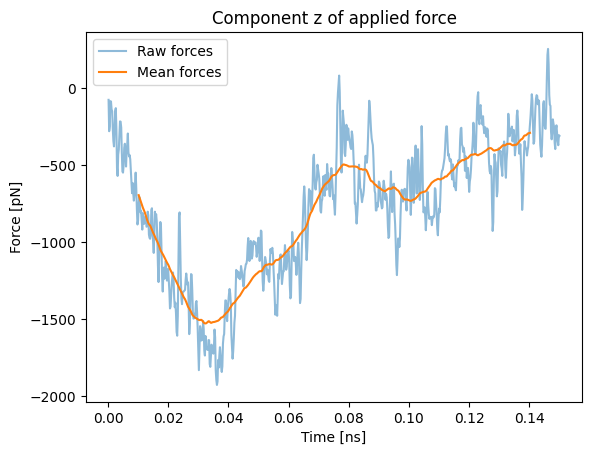

In [ ]:
#@title **Analyze force and calculate mean force**

data = np.loadtxt('./force_vs_time.dat')
times, forces = data[:,0]*timeStepSMD*100/1000000, data[:,-1]  # time in ns, forces in pN
df = pd.DataFrame({'time_ns': times.tolist(), 'force_pN': forces.tolist()})
df.to_csv(f'./forces.csv', index=False)
del df

# calculate mean force
def moving_average(y, window_size=10):
    return np.convolve(y, np.ones(window_size)/window_size, mode='valid')

window_size = 100
mean_forces = moving_average(forces, window_size)
mean_times = times[window_size//2:-window_size//2+1]

df = pd.DataFrame({'time_ns': mean_times.tolist(), 'force_pN': mean_forces.tolist()})
df.to_csv(f'./mean_forces.csv', index=False)

plt.plot(times, forces, alpha=0.5, label='Raw forces')
plt.plot(mean_times, mean_forces, label='Mean forces')
plt.xlabel('Time [ns]')
plt.ylabel('Force [pN]')
plt.title('Component z of applied force')
plt.legend()
plt.show()

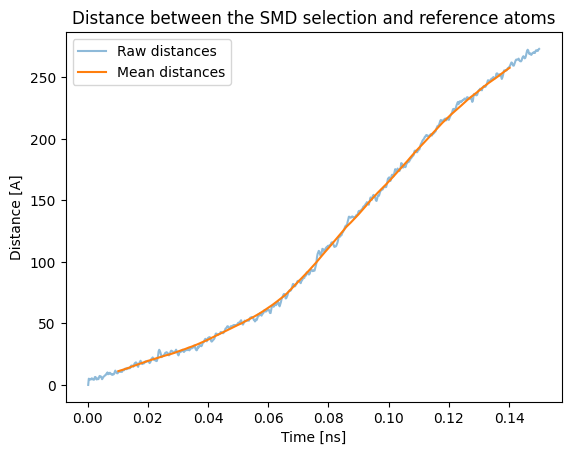

In [ ]:
#@title **Analyze distance and calculate average distance**
# distance is saved in file colvars.traj
data = np.loadtxt('./distance_vs_time.dat')
times, distances = data[:,0]*timeStepSMD*100/1000000, data[:,1]  # time in ns, position in A
df = pd.DataFrame({'time_ns': times.tolist(), 'distance_A': distances.tolist()})
df.to_csv(f'./distances.csv', index=False)
del df

window_size = 100
mean_distances = moving_average(distances, window_size)
mean_times = times[window_size//2:-window_size//2+1]

df = pd.DataFrame({'time_ns': mean_times.tolist(), 'distance_A': mean_distances.tolist()})
df.to_csv(f'./mean_distances.csv', index=False)

plt.plot(times, distances, alpha=0.5, label='Raw distances')
plt.plot(mean_times, mean_distances, label='Mean distances')
plt.xlabel('Time [ns]')
plt.ylabel('Distance [A]')
plt.title('Distance between the SMD selection and reference atoms')
plt.legend()
plt.show()

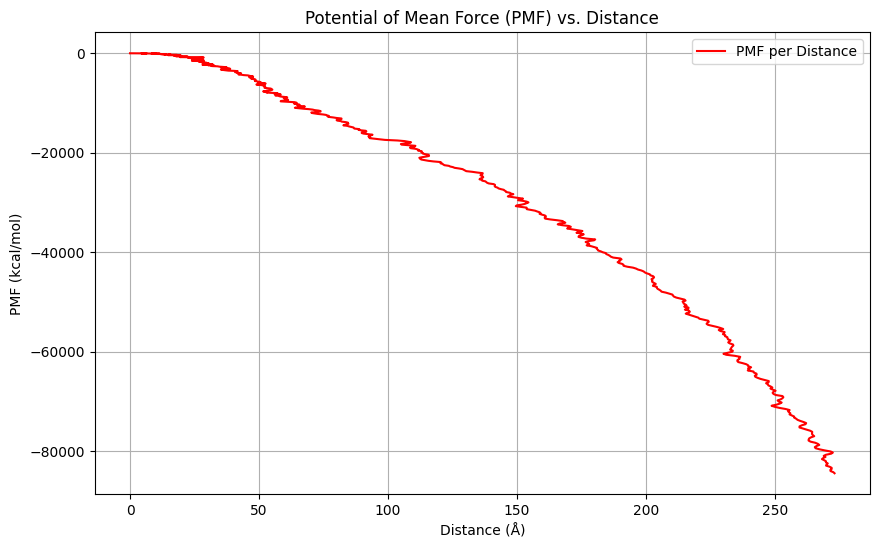

Data saved to pmf_data.csv


In [ ]:
#@title **Get PMF from SMD simulation**
from scipy.special import logsumexp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def read_data(force_file, distance_file, max_time_ns=1.0):
    """Read and filter force and distance data files based on a time threshold."""
    force_data = pd.read_csv(force_file)
    distance_data = pd.read_csv(distance_file)
    # Ensure that only data within the specified time is considered
    force_data = force_data[force_data['time_ns'] <= max_time_ns]
    distance_data = distance_data[distance_data['time_ns'] <= max_time_ns]
    return force_data, distance_data

def compute_cumulative_work(force_data, distance_data):
    """Compute cumulative work done using force and displacement data.
    Work units conversion:
        - Force (pN) to Newtons (N): multiply by 1e-12
        - Distance (Å) to meters (m): multiply by 1e-10
        - Work (J): force (N) * distance (m)
        - Convert Joules to kcal: 1 Joule ≈ 0.000239005736 Kilocalories
        - Convert kcal to kcal/mol by using Avogadro's number: multiply by Avogadro's number 6.022 1e-23

    """
    forces = force_data['force_pN'].values
    distances = distance_data['distance_A'].values
    # Pre-calculate conversion factor from pN*Å to kcal/mol directly
    conversion_factor = 1.44e-3  # pN*Å to kcal/mol
    work = np.zeros_like(forces)
    for i in range(1, len(forces)):
        work[i] = work[i-1] + forces[i] * (distances[i] - distances[i-1]) * conversion_factor
        #print (work[i])
    return work, distances

def calculate_pmf(work, temperature, distances):
    k_B = 0.001987  # Boltzmann constant in kcal/(mol*K)
    T = temperature
    beta = 1 / (k_B * T)
    cumulative_work = np.cumsum(work)  # Compute cumulative work once
    #print (cumulative_work)
    pmf = np.array([-1 / beta * logsumexp(-beta * cumulative_work[:i+1]) for i in range(len(work))])
    return pmf

def plot_pmf(distances, pmf, xmin=None, xmax=None):

    plt.figure(figsize=(10, 6))
    plt.plot(distances, pmf, linestyle='-', color='red', label='PMF per Distance')
    plt.title('Potential of Mean Force (PMF) vs. Distance')
    plt.xlabel('Distance (Å)')
    plt.ylabel('PMF (kcal/mol)')

    # Set x-axis limits if specified
    if xmin is not None or xmax is not None:
        plt.xlim(xmin, xmax)

    plt.legend()
    plt.grid(True)
    plt.show()

def save_pmf_data(distances, pmf, filename):
    """Save the calculated PMF data to a CSV file."""
    pmf_data = pd.DataFrame({'Distance (Å)': distances, 'PMF (kcal/mol)': pmf})
    pmf_data.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

def main(force_file, distance_file, temperature):
    """Main function to process data, calculate PMF, and generate plots."""
    force_data, distance_data = read_data(force_file, distance_file)
    work, distances = compute_cumulative_work(force_data, distance_data)
    pmf = calculate_pmf(work, float(temperature), distances)
    plot_pmf(distances, pmf)
    save_pmf_data(distances, pmf, 'pmf_data.csv')

# Replace 'force.csv', 'distance.csv', and 298 with your file names and simulation temperature
forceCSV = './forces.csv'        #@param {type:"string"}
distanceCSV = './distances.csv'  #@param {type:"string"}
temperature = "300"              #@param {type:"string"}
main(forceCSV, distanceCSV, temperature)

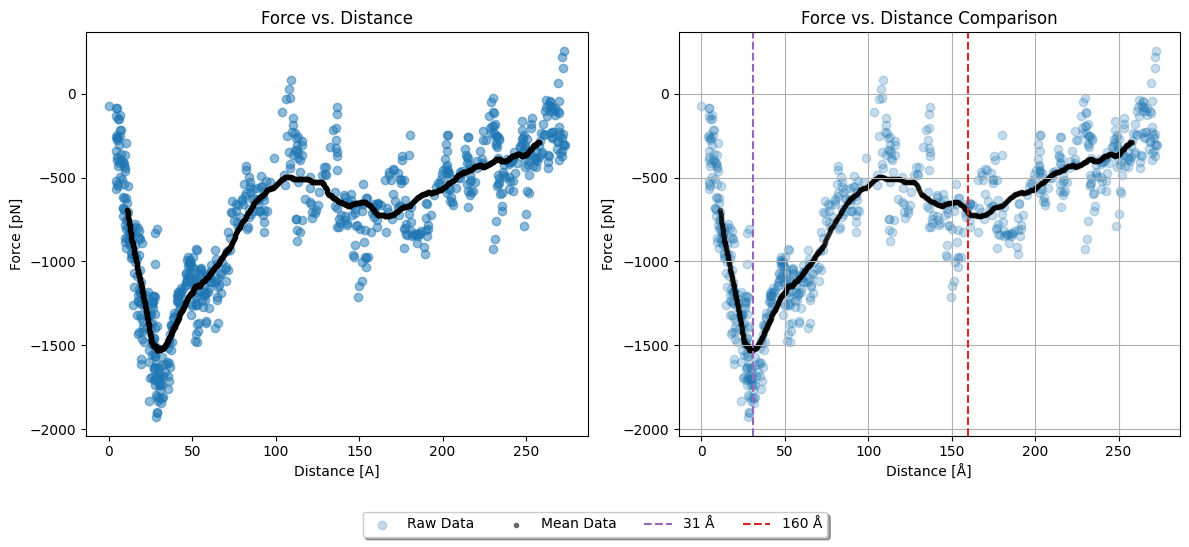

In [ ]:
#@title **Force as a function of the distance between compound and protein**
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the data from CSV files
forces_data = pd.read_csv('./forces.csv')
distances_data = pd.read_csv('./distances.csv')

mean_forces_data = pd.read_csv('./mean_forces.csv')
mean_distances_data = pd.read_csv('./mean_distances.csv')

# Since the times may not perfectly align, we join the data on the nearest time values
combined_data = pd.merge_asof(forces_data.sort_values('time_ns'), distances_data.sort_values('time_ns'), on='time_ns')
combined_mean_data = pd.merge_asof(mean_forces_data.sort_values('time_ns'), mean_distances_data.sort_values('time_ns'), on='time_ns')

# Plotting raw and mean forces vs distances
fig, axes = plt.subplots(1, 2, figsize=(12,5))
ax = axes[0]
ax.scatter(combined_data['distance_A'], combined_data['force_pN'], alpha=0.5, marker='o')
ax.scatter(combined_mean_data['distance_A'], combined_mean_data['force_pN'], color='k', marker='.')
ax.set_xlabel('Distance [A]')
ax.set_ylabel('Force [pN]')
ax.set_title('Force vs. Distance')

# Plotting raw forces vs distances
ax = axes[1]
ax.scatter(combined_data['distance_A'], combined_data['force_pN'], alpha=0.25, label='Raw Data', marker='o')
ax.scatter(combined_mean_data['distance_A'], combined_mean_data['force_pN'], alpha=0.5, color='k', label='Mean Data', marker='.')

# Take an average of 100 points over the mean force to better identify the peaks
ws = 100
trend_force = moving_average(mean_forces_data.force_pN.to_numpy(), ws)
trend_distance = mean_distances_data.distance_A.to_numpy()[ws//2:-ws//2+1]
# Get the indices of the peaks in the trend of the force curve
peaks, _ = find_peaks(-trend_force)
peaks = peaks[:6]
# Define important transitions with specific labels
transitions = {int(d): f'{int(d)} Å' for d in trend_distance[peaks]}

# Colors for each transition
colors = ['tab:purple', 'tab:red', 'tab:orange', 'tab:cyan', 'tab:olive', 'tab:green']

# Add vertical lines at transition distances with specific labels and unique colors
for (distance, label), color in zip(transitions.items(), colors):
    ax.axvline(x=distance, color=color, linestyle='--', label=f'{label}')

ax.set_xlabel('Distance [Å]')
ax.set_ylabel('Force [pN]')
ax.set_title('Force vs. Distance Comparison')
ax.grid(True)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02),
          fancybox=True, shadow=True, ncol=8)
plt.tight_layout()
plt.show()

# **ABF simulation of the drug-channel complex**

This notebook covers steps 9 and 10 of the hERG workflow.

9. For ABF, you need end-equ.pdb (end frame of equilibration) and smd_snaps.pdb (snaps from SMD trajectory, use get_smdsnaps.in)

10. Create a folder named merge. Copy all *.count and *.grad files to merge. The final equilibration restart.xsc file is needed.

In [ ]:
#@title **Get end of equilibration frame**

import os
os.chdir(abfDir)

import shutil
shutil.copy(f'{smdDir}/end-equ.pdb', f'{abfDir}/end-equ.pdb')

'/content/drive/My Drive/rank3/abf/end-equ.pdb'

In [ ]:
#@title **Get SMD snaps**
%%capture

# Write in file
content = """
parm ../common/hERG_popcwi.psf
trajin ../smd/smd.dcd 1 last 3
trajout ./smd_snaps.pdb PDB
run
quit
"""

inFile = os.path.join(abfDir, 'get_smd_snaps.in')
with open(inFile, 'w') as f:
    f.write(content)

# Run cpptraj from AmberTools
!cpptraj -i get_smd_snaps.in

## **ABF windows**

Creates PDB file for ABF windows and a windows_info file with the details of the window range, frame and UNK position.

- `get_pos.tcl` will generate the distance file from the `smd_snaps.pdb` and the `end-equ.pdb`
- `end-equ.pdb` will be saved as `win1A.pdb`
- The distance for `end-equ` will be set as `win1`

In [ ]:
#@title **Write get_pos.tcl file**
os.chdir(abfDir)

# input files
equFile = './end-equ.pdb'
smdFile = './smd_snaps.pdb'

print('End of equilibration frame:', equFile)
print('SMD snaps:', smdFile)

# write get_pos.tcl
tclFile = './get_pos.tcl'

content = f'mol load pdb {smdFile}' +\
"""
set lig [atomselect top "resname UNK"]
set prot [atomselect top "protein and name CA"]
set all [atomselect top "all"]
set nf [molinfo top get numframes]

for {set i 0} {$i < $nf} {incr i} {
  puts "frame $i of $nf"
  $prot frame $i
  $lig frame $i
  set compos($i.r) [expr [lindex [measure center $lig] 2] - [lindex [measure center $prot] 2]]
  set cp($i.r) [format "%.f" [expr floor($compos($i.r))]]
  set output2 [open "out_dist.txt" a+]
  puts $output2 "$i $compos($i.r) $cp($i.r)"
  close $output2
}
""" +\
f'mol load pdb {equFile}' +\
"""
set lig [atomselect top "resname UNK"]
set prot [atomselect top "protein and name CA"]
set all [atomselect top "all"]
$all writepdb win1A.pdb
set nf [molinfo top get numframes]
for {set i 0} {$i < $nf} {incr i} {
  puts "frame $i of $nf"
  $prot frame $i
  $lig frame $i
  set compos($i.r) [expr [lindex [measure center $lig] 2] - [lindex [measure center $prot] 2]]
  set cp($i.r) [format "%.f" [expr floor($compos($i.r))]]
  set output2 [open "out_dist.txt" a+]
  puts $output2 "$i $compos($i.r) $cp($i.r)"
  close $output2
}
exit 0
"""

with open(tclFile, 'w') as f:
    f.write(content)
    print(tclFile, "created successfully!")

End of equilibration frame: ./end-equ.pdb
SMD snaps: ./smd_snaps.pdb
./get_pos.tcl created successfully!


In [ ]:
#@title **Run get_pos.tcl**
%%capture
!vmd -dispdev text -e get_pos.tcl
!tr -d '\r' < out_dist.txt >> out.txt

In [ ]:
#@title **Get window intervals**

import numpy as np
os.chdir(abfDir)
out = np.loadtxt('out.txt')

# win1:
# aux = awk 'END {print $2}' out.txt
win1 = int(out[-1,1])
winstart = int(out[-1,1])
if win1%2!=0: win1 -= 1
# create additional variables for the required number of windows
# generate 13 windows
wsize = "2"       #@param {type:"string"}
numwindows = "12"  #@param {type:"string"}
wsize = int(wsize)
numwindows = int(numwindows)
winArray = [win1]
while len(winArray) < numwindows+1:
    winArray.append(np.round(winArray[-1] - wsize))

print('Windows:', winArray)
_ = winArray.pop(0)

Windows: [-4, -6, -8, -10, -12, -14, -16, -18, -20, -22, -24, -26, -28]


In [ ]:
#@title **Get pdb files for each window and write window_info.txt**
%%capture
import numpy as np
import os

# write info file
tclFile = "writepdb.tcl"
infoFile = "windows_info.txt"

range1, range2 = winArray[0]+1, win1+1,
frame = 0
contentINFO = "Window_start\tWindow_end\tFrame\tPosition\tWindow_name\n" +\
f"{range1}\t{range2}\t{frame}\t{winstart}\twin1A\n"

arr = np.loadtxt('out.txt')
for line in arr:
    frame, dist1, dist2 = line
    frame = int(frame)
    for i, (winSup, winInf) in enumerate(zip(winArray[:-1], winArray[1:])):
        pdbFile = f'win{i+2}A.pdb'
        if dist2 <= winSup and dist2 > winInf:
            if os.path.exists(pdbFile):
                print(f'{pdbFile} is already written')
                continue
            else:
                range1, range2 = winInf+1, winSup+1
                contentTCL = "mol load pdb smd_snaps.pdb\n" +\
                f"animate write pdb {pdbFile} beg {frame} end {frame} sel [atomselect top all]\n" +\
                "exit 0"
                with open(tclFile, 'w') as f:
                    f.write(contentTCL)
                !vmd -dispdev text -e writepdb.tcl
                print(f'\t{frame} with {dist1} is written as {pdbFile[:-4]}')
                contentINFO += f"{range1}\t{range2}\t{frame}\t{dist1}\t{pdbFile[:-4]}\n"

with open(infoFile, 'w') as f:
    f.write(contentINFO)

In [ ]:
#@title **Write conf files for each window**

timeStepABF = "2.0" #@param {type:"string"}
runStepsABF = "500000" #@param {type:"string"}

for i in range(1,numwindows+1):
    b = f'win{i}A'

    content = """
#############################################################
## JOB DESCRIPTION                                         ##
#############################################################

""" + f"# Adaptive Biased-Force Simulation {b}" +\
"""

#############################################################
## Adjustable Parameters                                   ##
#############################################################

""" + f"set outputname      {b}" +\
"""
firsttimestep       0
#############################################################
## Input Files                                             ##
#############################################################

cwd		              .
structure           ../common/hERG_popcwi.psf
""" + f"coordinates         ./{b}.pdb" +\
"""
paraTypeCharmm	    on
parameters          ../common/par_all27_prot_lipidNBFIX.prm
parameters	        ../common/par_all36_lipid.prm
parameters	        ../common/par_all36_prot.prm
parameters	        ../common/hit.par

# starting from Restart Files
set temperature     310
temperature         $temperature

set inputname       ../eq03/eq03_9
extendedSystem	    $inputname.restart.xsc

#############################################################
## Output Files                                            ##
#############################################################

outputName          $outputname
binaryoutput	      yes
restartfreq         1000
restartsave	        no
binaryrestart       yes
dcdfreq             2000
DCDUnitCell         yes
outputEnergies      1000
outputPressure      1000
outputMomenta	      100
outputTiming        1000

#############################################################
## SIMULATION PARAMETERS                                   ##
#############################################################

# Force-Field Parameters
exclude             scaled1-4
1-4scaling          1.0
switching           on
switchdist          12
cutoff              14
pairlistdist        16
outputPairlists     100

# Integrator Parameters
""" + f"timestep            {timeStepABF}" +\
"""
rigidBonds          all
rigidIterations     100
rigidDieOnError     on
nonbondedFreq       1
fullElectFrequency  2
MTSAlgorithm	      impulse
longSplitting       c1
stepspercycle       10

#############################################################
## EXTRA PARAMETERS                                        ##
#############################################################

# PME (for full-system periodic electrostatics)
FullDirect          no
PME                 yes
PMETolerance        10E-6
PMEInterpOrder      4

PMEGridSizeX        125
PMEGridSizeY        125
PMEGridSizeZ        120
FFTWEstimate	      no
FFTWUseWisdom	      yes

wrapNearest		      off
wrapAll             off

# Constant Temperature Control
langevin            on    ;# do langevin dynamics
langevinDamping     1     ;# damping coefficient (gamma) of 5/ps
langevinTemp        $temperature
langevinHydrogen    off    ;# don't couple langevin bath to hydrogens

# Constant Pressure Control (variable volume)
useGroupPressure      no ;# needed for rigidBonds
useFlexibleCell       no
useConstantArea       no

langevinPiston        on
langevinPistonTarget  1.01325 ;#  in bar -> 1 atm
langevinPistonPeriod  100.
langevinPistonDecay   50.
langevinPistonTemp    $temperature

#############################################################
## EXTRA PARAMETERS                                        ##
#############################################################
# Set constraints along z axis
colvars              on
""" + f"colvarsConfig        {b}.in\n" +\
"""
#############################################################
## EXECUTION SCRIPT                                        ##
#############################################################
""" + f"run {runStepsABF}"


    with open(f'{b}.conf', 'w') as f:
        f.write(content)
        print(f'{b}.conf', "created successfully!")

win1A.conf created successfully!
win2A.conf created successfully!
win3A.conf created successfully!
win4A.conf created successfully!
win5A.conf created successfully!
win6A.conf created successfully!
win7A.conf created successfully!
win8A.conf created successfully!
win9A.conf created successfully!
win10A.conf created successfully!
win11A.conf created successfully!
win12A.conf created successfully!


In [ ]:
#@title **Write colvars files for each window**
%%capture
import pandas as pd

windowData = pd.read_csv('windows_info.txt', sep='\t')

for i in range(1,numwindows+1):
    b = f'win{i}A'

    content = f"mol load pdb {b}.pdb" +\
    """
    set CA [atomselect top "protein and name CA"]
    set UNK [atomselect top "resname UNK"]
    set CASER [$CA get serial]
    set UNKSER [$UNK get serial]
    set ifile [open "indices.txt" w]
    puts $ifile "                atomnumbers { $UNKSER }
                 }
            ref {
                    atomnumbers { $CASER }
                 }
            axis (0.0, 0.0, 1.0 )
        }
    }"
    puts $ifile "    abf {"
    puts $ifile "       colvars Translocation"
    puts $ifile "       fullSamples 1000"
    puts $ifile "       hideJacobian    yes"
    puts $ifile "    }"
    set CAfile [open "CA.txt" w]
    puts $CAfile $CASER
    set UNKfile [open "UNK.txt" w]
    puts $UNKfile $UNKSER
    close $CAfile
    close $UNKfile
    close $ifile
    exit 0
    """

    with open(f'get_serial_{b}.tcl', 'w') as f:
        f.write(content)

    !vmd -dispdev text -e get_serial_{b}.tcl

    if b in windowData.Window_name.tolist():
        lower, upper = windowData.loc[i-1, 'Window_start'], windowData.loc[i-1, 'Window_end']
    else:
        continue

    content = """
    colvarsTrajFrequency      250
    colvarsRestartFrequency   250

    colvar {
        name Translocation

        width 0.1

    """ +\
    f"    lowerboundary   {lower}\n    upperboundary   {upper}\n\n" +\
    f"        lowerWall       {lower}\n    upperWall       {upper}\n" +\
    """
        lowerwallconstant 100.0
        upperwallconstant 100.0

        distanceZ {
            main {
    """

    with open("indices.txt", "r") as file:
        indices_content = file.read()
    content += indices_content

    with open(f'{b}.in', 'w') as f:
        f.write(content)

    !rm get_serial_*.tcl
    !rm CA.txt
    !rm UNK.txt
    # !rm indices.txt

In [ ]:
#@title **Run namd2**

n0 = 1
nl = n0+1
for i in range(n0, nl):
    conf = f'win{i}A.conf'
    log = f'win{i}A.log'
    if if_GPU:
      !$namd2 +p2 +devices 0 +idlepoll $conf > $log
    else:
      !$namd2 $conf > $log
    print(conf[:-5], 'Done')
    !tail -n 2 $log | head -n 1

win3A Done
WallClock: 37480.347656  CPUTime: 28219.216797  Memory: 723.367188 MB


# **Merge files**

In [ ]:
#@title **Copy grad and count files**

import os
import shutil
os.chdir(pmfDir)

for i in range(1,numwindows+1):
    b = f'win{i}A'
    print(b, end=' ')

    shutil.copy(f'{abfDir}/{b}.count', f'{pmfDir}/{b}.count')
    shutil.copy(f'{abfDir}/{b}.grad', f'{pmfDir}/{b}.grad')
print('copied')
shutil.copy(f'{abfDir}/win1A.pdb', f'{pmfDir}/win1A.pdb')

win1A win2A win3A win4A win5A win6A win7A win8A win9A win10A win11A win12A copied


'/content/drive/My Drive/rank3/merge/win1A.pdb'

In [ ]:
#@title **Create conf file**
timeStepABF = 2.0

content = """
#############################################################
## JOB DESCRIPTION                                         ##
#############################################################

# Merge results of ABF simulation

#############################################################
## Adjustable Parameters                                   ##
#############################################################

set outputname     merge
firsttimestep      0

#############################################################
## Input Files                                             ##
#############################################################

cwd		             .
structure          ../common/hERG_popcwi.psf
coordinates        win1A.pdb

paraTypeCharmm	   on
parameters         ../common/par_all27_prot_lipidNBFIX.prm
parameters	       ../common/par_all36_lipid.prm
parameters	       ../common/par_all36_prot.prm
parameters	       ../common/hit.par

# starting from Restart Files
set temperature    310
temperature        $temperature

set inputname      ../eq03/eq03_9
#binCoordinates    $inputname.restart.coor
#binVelocities     $inputname.restart.vel
extendedSystem	   $inputname.restart.xsc


#############################################################
## Output Files                                            ##
#############################################################

outputName          $outputname
binaryoutput	      yes
restartfreq         1000
restartsave	        no
binaryrestart       yes
dcdfreq             5000
DCDUnitCell         yes
outputEnergies      1000
outputPressure      1000
outputMomenta	      100
outputTiming        1000


#############################################################
## SIMULATION PARAMETERS                                   ##
#############################################################

# Force-Field Parameters
exclude             scaled1-4
1-4scaling          1.0
switching           on
switchdist          12
cutoff              14
pairlistdist        16
outputPairlists     100
#seed
#useSettle

# Integrator Parameters
""" + f"timestep            {timeStepABF}" +\
"""
rigidBonds          all
rigidIterations     100
rigidDieOnError     on
nonbondedFreq       1
fullElectFrequency  2
MTSAlgorithm	      impulse
longSplitting       c1
stepspercycle       10

#############################################################
## EXTRA PARAMETERS                                        ##
#############################################################
# PME (for full-system periodic electrostatics)

FullDirect          no
PME                 yes
PMETolerance        10E-6
PMEInterpOrder      4

PMEGridSizeX        162
PMEGridSizeY        162
PMEGridSizeZ        135
FFTWEstimate	      no
FFTWUseWisdom	      yes

wrapNearest		      off
wrapAll             off

# Constant Temperature Control
langevin            on    ;# do langevin dynamics
langevinDamping     1     ;# damping coefficient (gamma) of 5/ps
langevinTemp        $temperature
langevinHydrogen    off    ;# don't couple langevin bath to hydrogens

# Constant Pressure Control (variable volume)
useGroupPressure      no ;# needed for rigidBonds
useFlexibleCell       no
useConstantArea       no

langevinPiston        on
langevinPistonTarget  1.01325 ;#  in bar -> 1 atm
langevinPistonPeriod  100.
langevinPistonDecay   50.
langevinPistonTemp    $temperature

#############################################################
## EXTRA PARAMETERS                                        ##
#############################################################
# Set constraints along z axis
colvars              on
colvarsConfig        merge.in

run 0
"""

with open(f'merge.conf', 'w') as f:
    f.write(content)
    print(f'merge.conf', "created successfully!")

merge.conf created successfully!


In [ ]:
#@title **Create colvars file**
%%capture
import pandas as pd

os.chdir(pmfDir)
input = "inputPrefix "
for i in range(1,numwindows+1):
  input += f'win{i}A '

windowData = pd.read_csv('../abf/windows_info.txt', sep='\t')

content = """
mol load pdb win1A.pdb
set CA [atomselect top "protein and name CA"]
set UNK [atomselect top "resname UNK"]
set CASER [$CA get serial]
set UNKSER [$UNK get serial]
set ifile [open "indices.txt" w]
puts $ifile "            atomnumbers { $UNKSER }
          }
    ref {
            atomnumbers { $CASER }
          }
  axis (0.0, 0.0, 1.0 )
  }
}"
puts $ifile "abf {"
puts $ifile " colvars Translocation"
puts $ifile " outputFreq 0"
puts $ifile " fullSamples 1000"
puts $ifile " hideJacobian    yes"
""" +\
f'puts $ifile " {input}"' +\
"""
puts $ifile "}"
close $ifile
exit 0
"""

with open(f'get_serial.tcl', 'w') as f:
    f.write(content)

!vmd -dispdev text -e get_serial.tcl

lower, upper = windowData.loc[0, 'Window_end'], windowData.loc[numwindows-1, 'Window_start']

content = """
colvarsTrajFrequency      250
colvarsRestartFrequency   250

colvar {
    name Translocation

    width 0.1

""" +\
f"    lowerboundary   {upper}\n    upperboundary   {lower}\n\n" +\
f"    lowerWall       {upper}\n    upperWall       {lower}\n" +\
"""
    lowerwallconstant 100.0
    upperwallconstant 100.0

    distanceZ {
        main {
    """

with open("indices.txt", "r") as file:
    indices_content = file.read()
    content += indices_content

with open(f'merge.in', 'w') as f:
    f.write(content)

In [ ]:
#@title **Run namd2**

if if_GPU:
    !$namd2 +p2 +devices 0 +idlepoll merge.conf > merge.log
else:
    !$namd2 merge.conf > merge.log
!tail -n 15 merge.log

GPRESSURE: 0 4.28532 -30.6136 -159.376 50.8241 -124.246 24.9748 -126.435 34.3581 -20.4966
ETITLE:      TS           BOND          ANGLE          DIHED          IMPRP               ELECT            VDW       BOUNDARY           MISC        KINETIC               TOTAL           TEMP      POTENTIAL         TOTAL3        TEMPAVG            PRESSURE      GPRESSURE         VOLUME       PRESSAVG      GPRESSAVG

ENERGY:       0     14837.0375     45652.7127     32714.7986       811.6346        -404955.9949      7412.9541         0.0000        69.6679    110311.3790        -193145.8105       310.4281   -303457.1896   -192365.8279       310.4281            -62.9686       -46.8191   1580692.3871       -62.9686       -46.8191

WRITING EXTENDED SYSTEM TO OUTPUT FILE AT STEP 0
WRITING COORDINATES TO OUTPUT FILE AT STEP 0
COORDINATE DCD FILE merge.dcd WAS NOT CREATED
The last position output (seq=-2) takes 0.037 seconds, 676.273 MB of memory in use
WRITING VELOCITIES TO OUTPUT FILE AT STEP 0
The last 

Minimum found in -5.1 A with  0.0 kcal/mol


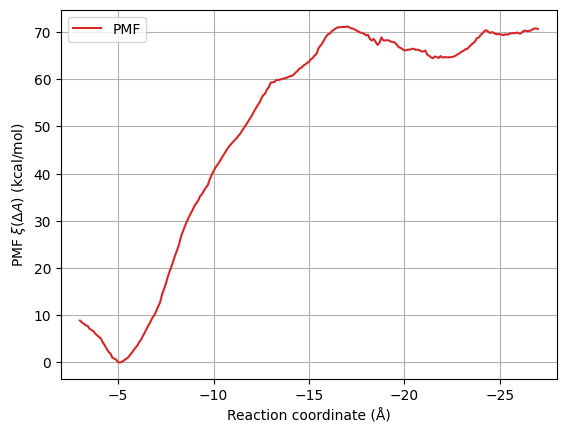

In [ ]:
#@title **Plot PMF**
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

os.chdir(pmfDir)
data = np.loadtxt('merge.pmf')
x, A = data[:,0], data[:,1]
idxmin = np.argmin(A)
target_distance = -x[idxmin]
print('Minimum found in', x[idxmin], 'A with ', A[idxmin], 'kcal/mol')
plt.plot(x, A, 'tab:red', label='PMF')
plt.xlim(x.max()+1, x.min()-1)
plt.xlabel('Reaction coordinate (Å)')
plt.ylabel(r'PMF $\xi$($\Delta A$) (kcal/mol)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#@title **Get frame that corresponds to the PMF minimum**
window_min = 'win2A' #@param {type:"string"}

content = """
set lig [atomselect top "resname UNK"]
set prot [atomselect top "protein and name CA"]
set all [atomselect top "all"]
set nf [molinfo top get numframes]

# Initialize variables
""" +\
f'set target_distance -{target_distance}' +\
"""
set closest_frame -1
set min_distance_diff [expr {abs($target_distance - 1.0e30)}]  ; # start with a large number

set output2 [open "dist_2.txt" w]
puts $output2 "frame distance difference"
close $output2

for {set i 0} {$i < $nf} {incr i} {
  $prot frame $i
  $lig frame $i
  set compos($i.r) [expr [lindex [measure center $lig] 2] - [lindex [measure center $prot] 2]]
  set cp($i.r) [format "%.f" [expr floor($compos($i.r))]]

  # Calculate the absolute difference from the target distance
  set distance_diff [expr {abs($compos($i.r) - $target_distance)}]

  # Check if this is the closest distance
  if {$distance_diff < $min_distance_diff} {
    set min_distance_diff $distance_diff
    set closest_frame $i
  }

  set output2 [open "dist_2.txt" a+]
  puts $output2 "$i $compos($i.r) $distance_diff"
  close $output2
}

# Output the frame number with the distance closest to the target distance
puts "The frame closest to the target distance of $target_distance is frame $closest_frame with a distance difference of $min_distance_diff."


# Save the PDB file for the closest frame
$all frame $closest_frame
$all writepdb "closest_frame.pdb"

exit 0
"""

with open('./get_pos3.tcl', 'w') as f:
    f.write(content)

window_file = f'../abf/{window_min}.dcd'
!vmd ../abf/end-equ.pdb -dcd $window_file -dispdev text -e get_pos3.tcl

Info) VMD for LINUXAMD64, version 1.9.3 (December 1, 2016)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 2 CPUs detected.
Info) Free system memory: 11GB (88%)
Info) Dynamically loaded 2 plugins in directory:
Info) /usr/local/lib/vmd/plugins/LINUXAMD64/molfile
Info) File loading in progress, please wait.
Info) Using plugin pdb for structure file ../abf/end-equ.pdb
Info) Using plugin pdb for coordinates from file ../abf/end-equ.pdb
Info) Determining bond structure from distance search ...
Info) Finished with coordinate file ../abf/end-equ.pdb.
Info) Analyzing structure ...
Info)    Atoms: 163903
Info)